# Stage 02: Exploratory Data Analysis (Part 5)

## Combined with PCL category labelling

### Load Dataset

In [136]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import itertools
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm

# project root (one level above notebooks)
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT))

from src.data.make_dataset import merge_pcl_task2_dataset, make_pcl_task2_dataset, make_pcl_task1_dataset

train_path = Path("../data/processed/pcl_task1_train.csv")
dev_path = Path("../data/processed/pcl_task1_dev.csv")
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

train2, dev2 = merge_pcl_task2_dataset(save=False)
print(train2["label_bin"].value_counts(normalize=True))
label_cols = [c for c in train2.columns if c not in ["par_id","art_id","keyword","country_code","text","label_0to4","label_bin"]]
print("All-zero category rows (should mostly be Non-PCL):", (train2[label_cols].sum(1) == 0).mean())
print("Detected labels:", label_cols)

label_bin
0    0.905194
1    0.094806
Name: proportion, dtype: float64
All-zero category rows (should mostly be Non-PCL): 0.9051940298507463
Detected labels: ['Authority_voice', 'Compassion', 'Metaphors', 'Presupposition', 'Shallow_solution', 'The_poorer_the_merrier', 'Unbalanced_power_relations']


## Check at paragraph level

### Check merge preserved task1 dataset

In [137]:
pcl = train2[train2.label_bin == 1].copy()
non = train2[train2.label_bin == 0].copy()

print("PCL rows:", len(pcl))
print("PCL rows with >=1 category:", (pcl[label_cols].sum(1) > 0).mean())
print("Non-PCL rows with >=1 category:", (non[label_cols].sum(1) > 0).mean())

PCL rows: 794
PCL rows with >=1 category: 1.0
Non-PCL rows with >=1 category: 0.0


In [138]:
train2["label_bin"].value_counts()

label_bin
0    7581
1     794
Name: count, dtype: int64

### PCL type distribution

In [139]:
# Prevalence within PCL
prev = pcl[label_cols].mean().sort_values(ascending=False)
display(prev)
# IE 72% of PCL paragraphs use unblanced power relations

Unbalanced_power_relations    0.722922
Compassion                    0.457179
Authority_voice               0.241814
Presupposition                0.204030
Shallow_solution              0.201511
Metaphors                     0.182620
The_poorer_the_merrier        0.036524
dtype: float64

### PCL type co-occurence

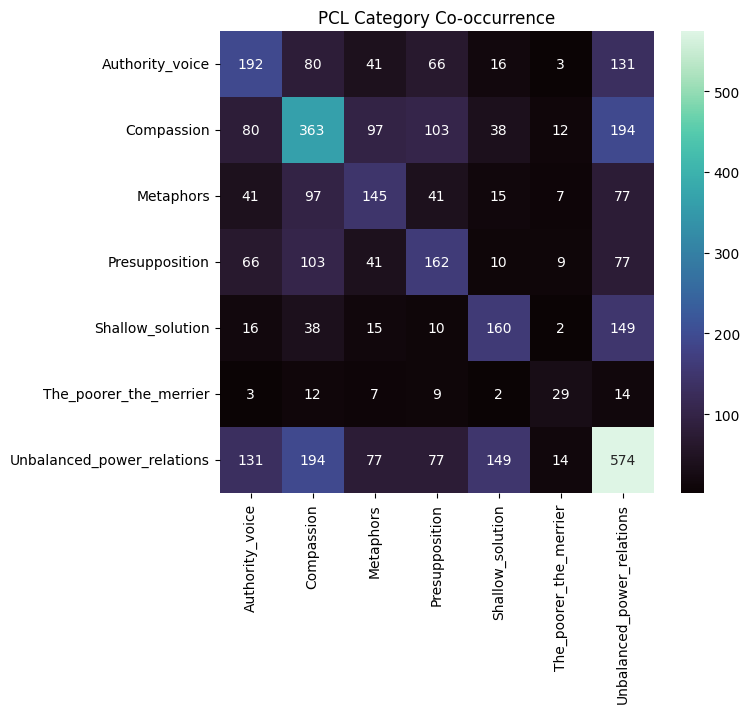

In [140]:
pcl_only = train2[train2.label_bin == 1]

co_matrix = pcl_only[label_cols].T @ pcl_only[label_cols]

plt.figure(figsize=(7,6))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="mako")
plt.title("PCL Category Co-occurrence")
plt.show()

### How many PCL strategies are used at once

['Authority_voice', 'Compassion', 'Metaphors', 'Presupposition', 'Shallow_solution', 'The_poorer_the_merrier', 'Unbalanced_power_relations']


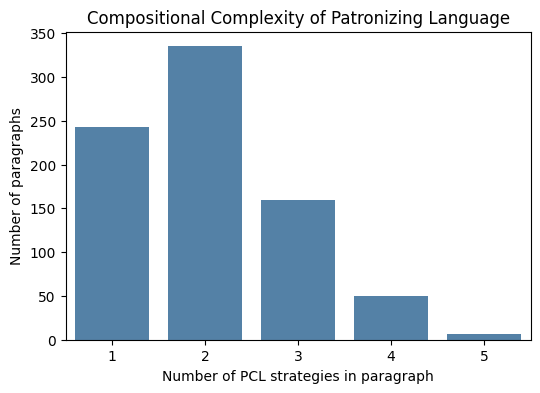

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

label_cols = [c for c in train2.columns if c in [
    'Authority_voice', 'Compassion', 'Metaphors', 'Presupposition', 'Shallow_solution', 'The_poorer_the_merrier', 'Unbalanced_power_relations'
]]

print(label_cols)

# number of strategies per paragraph (only PCL paragraphs)
pcl_only = train2[train2.label_bin == 1].copy()
pcl_only["num_strategies"] = pcl_only[label_cols].sum(axis=1)

plt.figure(figsize=(6,4))
sns.countplot(x="num_strategies", data=pcl_only, color="steelblue")
plt.xlabel("Number of PCL strategies in paragraph")
plt.ylabel("Number of paragraphs")
plt.title("Compositional Complexity of Patronizing Language")
plt.show()

- mostly 1-2 strategies used, rarely more than 3

### Most common multi-type strategies

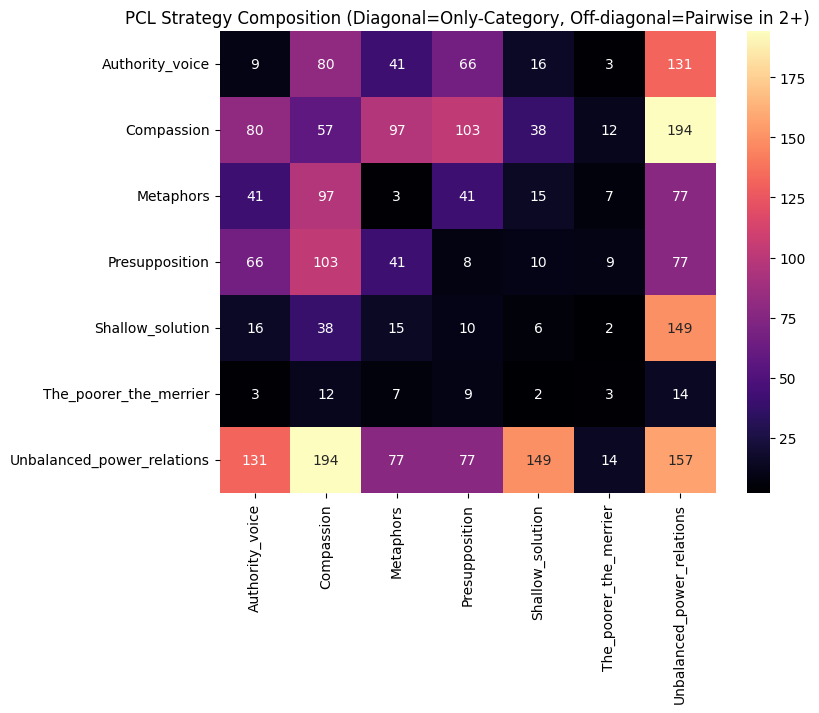

In [142]:
# Diagonal => Only this category (and no others)
# Off-diagonal => Co-occurrence in paragraphs with 2+ categories (so not counting the "only" cases)

pcl_only = train2[train2.label_bin == 1].copy()

M = pd.DataFrame(0, index=label_cols, columns=label_cols)

for _, row in pcl_only.iterrows():
    labels = [c for c in label_cols if row[c] == 1]
    k = len(labels)

    if k == 1:
        # diagonal = only this category and nothing else
        M.loc[labels[0], labels[0]] += 1

    else:
        # for k >= 2, only update off-diagonal pair counts
        for a, b in combinations(labels, 2):
            M.loc[a, b] += 1
            M.loc[b, a] += 1

plt.figure(figsize=(8,6))
sns.heatmap(M, annot=True, fmt="d", cmap="magma")
plt.title("PCL Strategy Composition (Diagonal=Only-Category, Off-diagonal=Pairwise in 2+)")
plt.show()

- Unbalanced power relations is the core signal — it appears most often alone and co-occurs with nearly every other strategy.
- PCL is compositional, not single-feature — most paragraphs combine multiple rhetorical strategies rather than relying on one.
- Compassion amplifies patronization — frequently layered on top of power framing to emotionalise the narrative.
- Authority voice & shallow solutions build a “saviour” narrative — speaking for and prescribing help to the target group.
- Metaphors & presupposition intensify framing — they strengthen implied helplessness rather than introduce new content.
- Overall: PCL is stylistic rhetoric, not topic-based — meaning arises from framing relationships between ideas, not keywords.

In [143]:
# only PCL paragraphs (since task2 labels only make sense there)
pcl_only = train2[train2.label_bin == 1].copy()

def get_labels(row):
    return tuple(sorted([c for c in label_cols if row[c] == 1]))

label_sets = pcl_only.apply(get_labels, axis=1)
combo_counts = Counter(label_sets)

print("num PCL paragraphs:", len(pcl_only))
print("num unique combos:", len(combo_counts))

num PCL paragraphs: 794
num unique combos: 65


In [144]:

# All combinations (any size) (top 15)
combos_df = (
    pd.DataFrame(combo_counts.items(), columns=["combo", "count"])
      .assign(size=lambda d: d["combo"].apply(len),
              combo_str=lambda d: d["combo"].apply(lambda t: " + ".join(t)))
      .sort_values(["count", "size"], ascending=[False, True])
      .reset_index(drop=True)
)

combos_df["percent"] = combos_df["count"] / len(pcl_only) *100
combos_df["cumulative_percent"] = combos_df["percent"].cumsum()

print("Top 15 PCL strategy combinations:")
display(combos_df.head(15)[["size", "combo_str", "count", "percent", "cumulative_percent"]])  # top 15
# display(combos_df[["size","combo_str","count"]])           # uncomment for all

# Exclusive single-category (size==1)
singles_df = combos_df[combos_df["size"] == 1].copy()
singles_df["category"] = singles_df["combo"].apply(lambda t: t[0])
singles_df = singles_df[["category", "count"]].sort_values("count", ascending=False).reset_index(drop=True)
singles_df["percent"] = singles_df["count"] / len(pcl_only) *100

# Exact pairs only (size==2)
pairs_df = combos_df[combos_df["size"] == 2].copy()
pairs_df[["cat1","cat2"]] = pd.DataFrame(pairs_df["combo"].tolist(), index=pairs_df.index)
pairs_df = pairs_df[["cat1","cat2","count"]].sort_values("count", ascending=False).reset_index(drop=True)
pairs_df["percent"] = pairs_df["count"] / len(pcl_only) *100

print("Standalone strategy counts (exclusive):")
display(singles_df)

print("Exact pair counts (only-two-strategy paragraphs) — top 15:")
display(pairs_df.head(15))  # remove head(15) to show all pairs



rows = []

# singletons
for c in label_cols:
    cnt = int(M.loc[c, c])
    if cnt > 0:
        rows.append((1, c, "", cnt))

# pairwise co-occurrence (off-diagonal)
for i, a in enumerate(label_cols):
    for b in label_cols[i+1:]:
        cnt = int(M.loc[a, b])
        if cnt > 0:
            rows.append((2, a, b, cnt))

combo_table = pd.DataFrame(rows, columns=["size", "cat1", "cat2", "count"])

total_events = combo_table["count"].sum()
combo_table["fraction"] = combo_table["count"] / total_events * 100

combo_table = combo_table.sort_values("count", ascending=False).reset_index(drop=True)

display(combo_table.head(15))
print("Total events counted (singletons + pair-events):", total_events)
# display(combo_table)  # full table

Top 15 PCL strategy combinations:


,size,combo_str,count,percent,cumulative_percent
0,1,Unbalanced_power_relations,157,19.773300,19.773300
1,2,Shallow_solution + Unbalanced_power_relations,91,11.460957,31.234257
2,2,Compassion + Unbalanced_power_relations,77,9.697733,40.931990
3,1,Compassion,57,7.178841,48.110831
4,2,Authority_voice + Unbalanced_power_relations,50,6.297229,54.408060
5,2,Compassion + Presupposition,28,3.526448,57.934509
6,2,Compassion + Metaphors,27,3.400504,61.335013
7,3,Compassion + Shallow_solution + Unbalanced_pow...,25,3.148615,64.483627
8,3,Authority_voice + Compassion + Unbalanced_powe...,19,2.392947,66.876574
9,2,Metaphors + Unbalanced_power_relations,18,2.267003,69.143577


Standalone strategy counts (exclusive):


,category,count,percent
0,Unbalanced_power_relations,157,19.773300
1,Compassion,57,7.178841
2,Authority_voice,9,1.133501
3,Presupposition,8,1.007557
4,Shallow_solution,6,0.755668
5,Metaphors,3,0.377834
6,The_poorer_the_merrier,3,0.377834


Exact pair counts (only-two-strategy paragraphs) — top 15:


,cat1,cat2,count,percent
0,Shallow_solution,Unbalanced_power_relations,91,11.460957
1,Compassion,Unbalanced_power_relations,77,9.697733
2,Authority_voice,Unbalanced_power_relations,50,6.297229
3,Compassion,Presupposition,28,3.526448
4,Compassion,Metaphors,27,3.400504
5,Metaphors,Unbalanced_power_relations,18,2.267003
6,Authority_voice,Compassion,11,1.385390
7,Authority_voice,Presupposition,10,1.259446
8,Presupposition,Unbalanced_power_relations,7,0.881612
9,The_poorer_the_merrier,Unbalanced_power_relations,4,0.503778


,size,cat1,cat2,count,fraction
0,2,Compassion,Unbalanced_power_relations,194,13.614035
1,1,Unbalanced_power_relations,,157,11.017544
2,2,Shallow_solution,Unbalanced_power_relations,149,10.456140
3,2,Authority_voice,Unbalanced_power_relations,131,9.192982
4,2,Compassion,Presupposition,103,7.228070
5,2,Compassion,Metaphors,97,6.807018
6,2,Authority_voice,Compassion,80,5.614035
7,2,Presupposition,Unbalanced_power_relations,77,5.403509
8,2,Metaphors,Unbalanced_power_relations,77,5.403509
9,2,Authority_voice,Presupposition,66,4.631579


Total events counted (singletons + pair-events): 1425


- 50% of PCL strategies is covered by top 4 PCL strategy combinations
    - Unbalanced power              20%
    - Unbalanced power + shallow    11%
    - Unbalanced power + compassion 10%
    - Compassion                    7%
- too unbalanced tbh

## Check at Span level

- to see if more balanced and easier to label uniquely and isolate specific phrases
- turns out they are!!!

### Aggregate same spans together

In [145]:
span_df = make_pcl_task2_dataset(save=False)

In [146]:
# Identify the one-hot label columns (already in spans_df from export_task2_spans_dataset)
meta_cols = [
    "par_id","art_id","text","keyword","country_code",
    "span_start","span_finish","span_text","category","n_annotators"
]
label_cols = [c for c in span_df.columns if c not in meta_cols]

# Define what makes a "unique span"
span_key = ["par_id", "span_start", "span_finish", "span_text"]

# Aggregate: one row per unique span, multi-hot labels = max, keep useful metadata
spans_agg = (
    span_df
    .groupby(span_key, as_index=False)
    .agg({
        "art_id": "first",
        "text": "first",
        "keyword": "first",
        "country_code": "first",
        "n_annotators": "max",        # keep best agreement
        **{c: "max" for c in label_cols}
    })
)

# How many labels each span has (multi-label span)
spans_agg["num_labels"] = spans_agg[label_cols].sum(axis=1)

print("Original rows:", len(span_df))
print("Unique spans:", len(spans_agg))
print("Multi-label spans (%):", (spans_agg["num_labels"] > 1).mean())

Original rows: 2760
Unique spans: 2557
Multi-label spans (%): 0.07665232694563942


In [147]:
multi_label_spans = spans_agg[spans_agg["num_labels"] > 1].sort_values("num_labels", ascending=False)
display(multi_label_spans.head(10))

,par_id,span_start,span_finish,span_text,art_id,text,keyword,country_code,n_annotators,Authority_voice,Compassion,Metaphors,Presupposition,Shallow_solution,The_poorer_the_merrier,Unbalanced_power_relations,num_labels
1894,7568,0,93,"Today , homeless women are still searching for...",@@671981,"Today , homeless women are still searching for...",homeless,ca,1,1,1,0,1,0,0,0,3
2552,10468,193,223,You gave hope to the hopeless,@@16753236,""" Anja Ringgren Loven I ca n't find a word to ...",hopeless,in,2,0,1,0,1,0,0,1,3
454,1570,41,90,gave sight to the blind and hope to the hopeless,@@10287498,"He said the Eye Clinic started in 1997 , gave ...",hopeless,gh,2,0,1,1,0,0,0,1,3
2003,8057,0,66,"For jobless , hopeless Zimbabweans there is no...",@@21859710,"For jobless , hopeless Zimbabweans there is no...",hopeless,hk,2,1,1,0,1,0,0,0,3
791,2997,62,116,I hope to be the Rosa Parks of the disabled co...,@@2251241,Daily discrimination facing the disabled in ev...,disabled,ie,1,1,0,1,0,0,0,1,3
596,2316,24,157,"A refugee is a person , with a story , a life ...",@@14172407,A refugee is that boy . A refugee is a person ...,refugee,hk,1,1,1,0,0,0,0,1,3
1129,4527,118,164,hoping that someone will come to their rescue,@@15517306,For now the families are staying with friends ...,in-need,za,2,0,1,0,1,0,0,1,3
1809,7171,220,312,too ignorant to understand that those division...,@@1934487,The only force capable of stopping them is the...,hopeless,ng,1,0,0,0,1,0,0,1,2
1677,6699,138,175,break away from the cycle of poverty,@@4557972,He said their efforts should not stop only at ...,poor-families,my,1,0,1,1,0,0,0,0,2
1693,6821,90,233,But for the people who live on the ground in t...,@@2718131,"That is the big picture , the one conveyed in ...",hopeless,za,1,0,0,0,1,0,0,1,2


In [148]:
print("Exact duplicates:", spans_agg.duplicated().sum())

print("Duplicate spans:",
      spans_agg.duplicated(
          subset=["par_id","span_start","span_finish","span_text"]
      ).sum())

Exact duplicates: 0
Duplicate spans: 0


### How separable/co-occuring are span PCL types

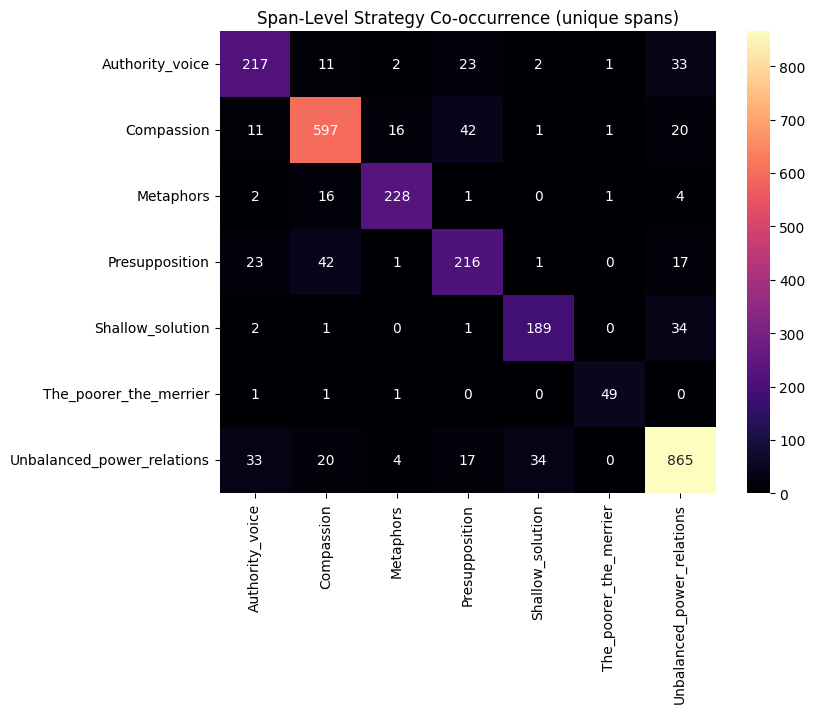

,size,combo_str,count,percent,cumulative
0,1,Unbalanced_power_relations,865,33.828706,33.828706
1,1,Compassion,597,23.347673,57.176379
2,1,Metaphors,228,8.916699,66.093078
3,1,Authority_voice,217,8.486508,74.579585
4,1,Presupposition,216,8.447399,83.026985
5,1,Shallow_solution,189,7.391474,90.418459
6,1,The_poorer_the_merrier,49,1.916308,92.334767
7,2,Compassion + Presupposition,38,1.486117,93.820884
8,2,Shallow_solution + Unbalanced_power_relations,34,1.329683,95.150567
9,2,Authority_voice + Unbalanced_power_relations,31,1.212358,96.362925


Total unique combinations: 29


In [149]:
# Build label sets per span (tuple of active labels)
span_label_sets = spans_agg.apply(
    lambda r: tuple(sorted([c for c in label_cols if r[c] == 1])),
    axis=1
)

# Co-occurrence matrix at SPAN level
M_span = pd.DataFrame(0, index=label_cols, columns=label_cols)

for ls in span_label_sets:
    k = len(ls)
    if k == 1:
        M_span.loc[ls[0], ls[0]] += 1
    elif k >= 2:
        for a, b in combinations(ls, 2):
            M_span.loc[a, b] += 1
            M_span.loc[b, a] += 1

plt.figure(figsize=(8,6))
sns.heatmap(M_span, annot=True, fmt="d", cmap="magma")
plt.title("Span-Level Strategy Co-occurrence (unique spans)")
plt.show()

# Ranked combinations (any size) 
combo_counts = Counter(span_label_sets)

combo_df = (
    pd.DataFrame(combo_counts.items(), columns=["combo", "count"])
    .assign(
        size=lambda d: d["combo"].apply(len),
        combo_str=lambda d: d["combo"].apply(lambda t: " + ".join(t) if len(t) else "(none)")
    )
    .sort_values(["count", "size"], ascending=[False, True])
    .reset_index(drop=True)
)

total = combo_df["count"].sum()
combo_df["percent"] = combo_df["count"] / total
combo_df["cumulative"] = combo_df["percent"].cumsum() *100
combo_df["percent"] = combo_df["percent"] *100

display(combo_df[["size", "combo_str", "count", "percent", "cumulative"]])
print("Total unique combinations:", len(combo_df))

### Span length profiling wrt paragraph

- Massive difference at span-level; unique class labelling up to 92% of dataset
    - 92% PCL combos use 1 type
    - much cleaner than paragraph level 
- hardly any co-occurrence
- Only 3 span-level examples have 3+ labels, rest uses mostly 1 or 2
- PCL(Paragraph) ~ P(presence of rhetorical span)

- Spans are sparse and localised so paragraph embeddings will wash out signal
    - why linear & even long context models struggle but attention helps
- From span perspective PCL categories are a much stronger signal that are less noisy and more distinct
- Spans may provide many (dense) psotivie PCL labels which may solve class imbalance

In [150]:
# character + token length for spans
spans_agg["span_char_len"] = spans_agg["span_text"].str.len()
spans_agg["span_token_len"] = spans_agg["span_text"].str.split().apply(len)

# paragraph length
para_len = train2[["par_id","text"]].drop_duplicates().copy()
para_len["para_char_len"] = para_len["text"].str.len()
para_len["para_token_len"] = para_len["text"].str.split().apply(len)

print("SPAN TOKEN STATS")
print(spans_agg["span_token_len"].describe(percentiles=[.5,.75,.9,.95,.99]))

print("\nPARAGRAPH TOKEN STATS")
print(para_len["para_token_len"].describe(percentiles=[.5,.75,.9,.95,.99]))

SPAN TOKEN STATS
count    2557.000000
mean       16.418459
std        11.847331
min         1.000000
50%        14.000000
75%        22.000000
90%        32.000000
95%        39.000000
99%        55.000000
max       138.000000
Name: span_token_len, dtype: float64

PARAGRAPH TOKEN STATS
count    8375.000000
mean       48.675224
std        29.677952
min         1.000000
50%        42.000000
75%        60.000000
90%        84.000000
95%       102.000000
99%       142.000000
max       909.000000
Name: para_token_len, dtype: float64


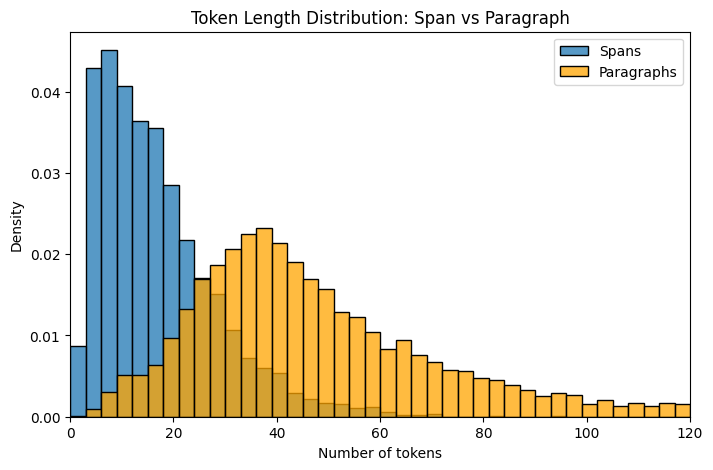

In [151]:
plt.figure(figsize=(8,5))
bins = np.linspace(0, 120, 41)   # 40 identical bins

sns.histplot(spans_agg["span_token_len"], bins=bins, stat="density", label="Spans")
sns.histplot(para_len["para_token_len"], bins=bins, stat="density", label="Paragraphs", color="orange")
plt.xlim(0, 120)
plt.legend()
plt.title("Token Length Distribution: Span vs Paragraph")
plt.xlabel("Number of tokens")
plt.show()

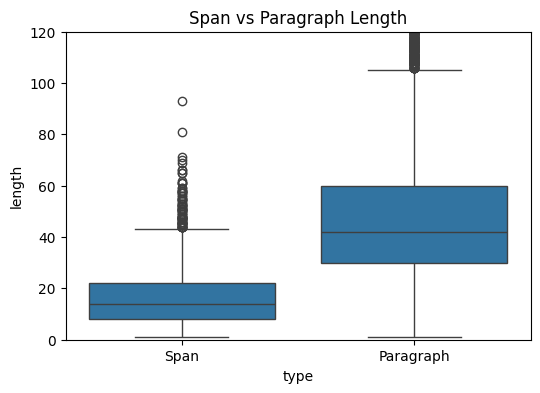

In [152]:
plot_df = pd.DataFrame({
    "length": list(spans_agg["span_token_len"]) + list(para_len["para_token_len"]),
    "type": ["Span"]*len(spans_agg) + ["Paragraph"]*len(para_len)
})

plt.figure(figsize=(6,4))
sns.boxplot(data=plot_df, x="type", y="length")
plt.ylim(0,120)
plt.title("Span vs Paragraph Length")
plt.show()

- according to mean & median roughly 3 spans can fit in a paragraph

### Span overlap detection

In [153]:
# Printable copy with a collapsed category string
spans_print = spans_agg.copy()

# figure out which columns are the one-hot labels
meta_cols = {"par_id","art_id","text","keyword","country_code",
             "span_start","span_finish","span_text","n_annotators","num_labels"}
label_cols = [c for c in spans_print.columns if c not in meta_cols]

# abbreviations (adjust if your exact column names differ)
abbr = {
    "Unbalanced_power_relations": "UPR",
    "Compassion": "COMP",
    "Authority_voice": "AUTH",
    "Shallow_solution": "SHAL",
    "Presupposition": "PRES",
    "Metaphors": "META",
    "The_poorer_the_merrier": "PTM",
}

def collapse_category(row):
    labs = [c for c in label_cols if row[c] == 1]
    # abbreviate, fallback to first 6 letters if missing
    labs = [abbr.get(c, c[:6].upper()) for c in labs]
    return ",".join(labs) if labs else "NONE"

spans_print["category"] = spans_print.apply(collapse_category, axis=1)

In [154]:
def overlaps(a, b):
    # strict overlap (not identical, not just touching)
    return (a["span_start"] < b["span_finish"]) and (b["span_start"] < a["span_finish"]) \
           and not (a["span_start"] == b["span_start"] and a["span_finish"] == b["span_finish"])


overlap_pairs = 0
total_pairs = 0
paragraphs_with_overlap = 0

# store examples to print later
overlap_examples = []   # list of (par_id, text, [(a,b), (a,b), ...])

MAX_PARAGRAPHS_TO_PRINT = 10
MAX_PAIRS_PER_PAR = 5

for pid, group in spans_print.groupby("par_id"):
    spans = group.to_dict("records")
    found_pairs = []

    for i in range(len(spans)):
        for j in range(i+1, len(spans)):
            total_pairs += 1
            if overlaps(spans[i], spans[j]):
                overlap_pairs += 1
                found_pairs.append((spans[i], spans[j]))

    if found_pairs:
        paragraphs_with_overlap += 1

        # save a few for printing
        if len(overlap_examples) < MAX_PARAGRAPHS_TO_PRINT:
            text = group.iloc[0]["text"]
            overlap_examples.append((pid, text, found_pairs[:MAX_PAIRS_PER_PAR]))

print("Overlapping span pairs:", overlap_pairs)
print("Total span pairs:", total_pairs)
print("Pair overlap rate:", overlap_pairs / total_pairs if total_pairs else 0)

print("\nParagraphs containing ANY overlap:", paragraphs_with_overlap)
print("Paragraph overlap rate:", paragraphs_with_overlap / spans_agg.par_id.nunique())

# ---- Print grouped examples ----
for pid, text, pairs in overlap_examples:
    print("\n" + "="*90)
    print(f"PARAGRAPH {pid} (showing up to {MAX_PAIRS_PER_PAR} overlaps)")
    print("-"*90)
    print(text)

    for a, b in pairs:
        start = min(a["span_start"], b["span_start"])
        end   = max(a["span_finish"], b["span_finish"])

        print("\nOVERLAP:")
        print(f"  [{a.get('category','?')}] ({a['span_start']},{a['span_finish']}): {a['span_text']}")
        print(f"  [{b.get('category','?')}] ({b['span_start']},{b['span_finish']}): {b['span_text']}")

Overlapping span pairs: 1106
Total span pairs: 3339
Pair overlap rate: 0.3312368972746331

Paragraphs containing ANY overlap: 560
Paragraph overlap rate: 0.5639476334340383

PARAGRAPH 77 (showing up to 5 overlaps)
------------------------------------------------------------------------------------------
In September , Major Nottle set off on foot from Melbourne to Canberra to plead for a national solution to the homeless problem .

OVERLAP:
  [UPR] (15,128): Major Nottle set off on foot from Melbourne to Canberra to plead for a national solution to the homeless problem
  [SHAL] (28,71): set off on foot from Melbourne to Canberra

PARAGRAPH 118 (showing up to 5 overlaps)
------------------------------------------------------------------------------------------
This is the rhetoric of what anthropologist Laura Agust ? n calls the " rescue industry " - a term used to describe people and institutions who conceptualize all sex workers as victims in need of saving . Catherine MacKinnon has a

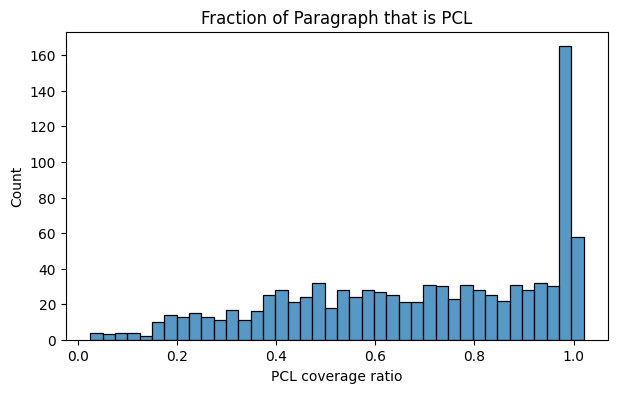

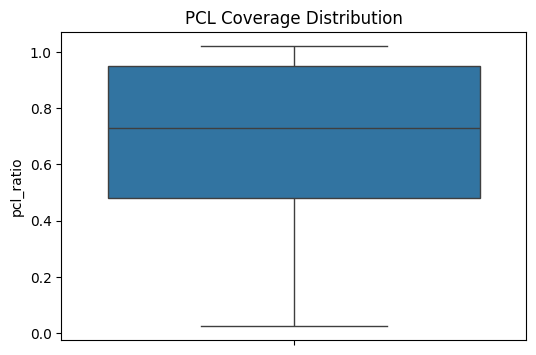

count    993.000000
mean       0.690654
std        0.262131
min        0.025424
25%        0.482270
50%        0.728883
75%        0.950382
90%        0.993630
95%        0.995734
99%        1.015645
max        1.020408
Name: pcl_ratio, dtype: float64

In [155]:
def merged_coverage(spans):
    """
    spans: list of (start, end)
    returns total covered length after merging overlaps
    """
    if not spans:
        return 0
    
    spans = sorted(spans)
    merged = [spans[0]]

    for start, end in spans[1:]:
        last_start, last_end = merged[-1]
        if start <= last_end:  # overlap
            merged[-1] = (last_start, max(last_end, end))
        else:
            merged.append((start, end))

    return sum(end - start for start, end in merged)

coverage = []

for pid, group in spans_agg.groupby("par_id"):
    text = group.iloc[0]["text"]
    para_len = len(text)

    spans = list(zip(group["span_start"], group["span_finish"]))
    pcl_chars = merged_coverage(spans)

    coverage.append({
        "par_id": pid,
        "paragraph_len": para_len,
        "pcl_chars": pcl_chars,
        "pcl_ratio": pcl_chars / para_len if para_len else 0
    })

coverage_df = pd.DataFrame(coverage)

plt.figure(figsize=(7,4))
sns.histplot(coverage_df["pcl_ratio"], bins=40)
plt.title("Fraction of Paragraph that is PCL")
plt.xlabel("PCL coverage ratio")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(y=coverage_df["pcl_ratio"])
plt.title("PCL Coverage Distribution")
plt.show()

coverage_df["pcl_ratio"].describe(percentiles=[.25,.5,.75,.9,.95,.99])

- It seems 70% of PCL paragraphs are covered with PCL indiciative language

### PCA Embeddings

In [157]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

SEED = 0
rng = np.random.default_rng(SEED)

# span length stats you measured
SPAN_LEN_MEAN = 16
SPAN_LEN_STD  = 11
SPAN_LEN_MIN, SPAN_LEN_MAX = 3, 60  # clamp

def word_tokens(s: str):
    # simple + fast; consistent with your earlier EDA
    return str(s).split()

In [158]:
import re
import string

# --- span quality filters ---
LEADING_PUNCT_RE = re.compile(rf"^[{re.escape(string.punctuation)}]+")
STARTS_WITH_LETTER_RE = re.compile(r"^[A-Za-z]")
ENDS_WITH_PUNCT_RE = re.compile(r"[.!?\"']$")

BAD_START_CHARS = set(",.;:)]}!?\"'")


def is_valid_span(span_text: str) -> bool:
    s = span_text.strip()
    if not s:
        return False

    # avoid clipped fragments
    if s[0] in BAD_START_CHARS:
        return False
    if LEADING_PUNCT_RE.match(s):
        return False

    # prefer natural sentence starts
    if not STARTS_WITH_LETTER_RE.match(s):
        return False

    # prefer natural sentence endings
    if not ENDS_WITH_PUNCT_RE.search(s):
        return False

    return True


def sample_negative_spans_from_nonpcl(
    train_df: pd.DataFrame,
    n_samples: int,
    mean_len: int = SPAN_LEN_MEAN,
    std_len: int = SPAN_LEN_STD,
    min_len: int = SPAN_LEN_MIN,
    max_len: int = SPAN_LEN_MAX,
    seed: int = SEED,
    max_tries_per_par: int = 25,
    max_total_tries: int = 200000,
) -> pd.DataFrame:

    rng = np.random.default_rng(seed)

    nonpcl = (
        train_df.loc[train_df.label_bin == 0, ["par_id", "text"]]
        .drop_duplicates()
        .sample(frac=1, random_state=seed)
        .reset_index(drop=True)
    )

    rows = []
    i = 0
    total_tries = 0

    while len(rows) < n_samples and total_tries < max_total_tries:
        pid, text = nonpcl.iloc[i % len(nonpcl)]
        i += 1

        tokens = word_tokens(text)
        if len(tokens) < min_len:
            continue

        for _ in range(max_tries_per_par):
            total_tries += 1
            if total_tries >= max_total_tries:
                break

            L = int(np.clip(rng.normal(mean_len, std_len), min_len, min(max_len, len(tokens))))
            if len(tokens) < L:
                continue

            start = rng.integers(0, len(tokens) - L + 1)
            span_text = " ".join(tokens[start:start + L]).strip()

            if is_valid_span(span_text):
                rows.append({"par_id": pid, "span_text": span_text, "span_len": L})
                break

    if len(rows) < n_samples:
        print(f"Warning: sampled {len(rows)}/{n_samples} negative spans.")

    return pd.DataFrame(rows)


# ---- build span-level binary dataset ----

# positive spans (annotated)
pos_df = spans_agg[["par_id", "span_text"]].copy()
pos_df["label"] = 1
pos_df["span_len"] = pos_df["span_text"].apply(lambda x: len(word_tokens(x)))

# negative spans (sampled)
neg_df = sample_negative_spans_from_nonpcl(train_df, n_samples=len(pos_df))
neg_df["label"] = 0

# combined dataset
span_bin_df = (
    pd.concat([pos_df, neg_df], ignore_index=True)
      .sample(frac=1, random_state=SEED)
      .reset_index(drop=True)
)

print("Pos:", len(pos_df), "Neg:", len(neg_df), "Total:", len(span_bin_df))
span_bin_df.head()

Pos: 2557 Neg: 2557 Total: 5114


,par_id,span_text,label,span_len
0,197,we have a responsibility to help the world 's ...,1,17
1,6133,This sense of hopelessness is the root cause o...,1,12
2,1137,has shown its commitment to Jamaica by again p...,1,18
3,3253,It was not immediately clear how many Rohingya...,0,33
4,2154,we need similar witness so that mercy can reac...,1,12


In [159]:
# check quality of negative samples
neg_samples = neg_df.sample(20, random_state=0).copy()

# extra attributes
neg_samples["char_len"] = neg_samples["span_text"].str.len()
neg_samples["word_len"] = neg_samples["span_text"].str.split().str.len()
neg_samples["has_quote"] = neg_samples["span_text"].str.contains(r"['\"\“\”]", regex=True)
neg_samples["has_ellipsis"] = neg_samples["span_text"].str.contains(r"\.\.\.|…", regex=True)
neg_samples["has_url"] = neg_samples["span_text"].str.contains(r"http|www\.", regex=True)
neg_samples["starts_lower"] = neg_samples["span_text"].str[:1].str.islower()
neg_samples["ends_punct"] = neg_samples["span_text"].str.rstrip().str.contains(r"[.!?]$", regex=True)

display_cols = ["par_id", "span_text", "span_len", "word_len", "char_len",
                "has_quote", "has_ellipsis", "has_url", "starts_lower", "ends_punct"]

neg_samples[display_cols]

,par_id,span_text,span_len,word_len,char_len,has_quote,has_ellipsis,has_url,starts_lower,ends_punct
602,1445,provisional nature of some of the Brussels dea...,18,18,100,True,False,False,True,False
563,3367,"better path because Ghanaians are tired , ther...",17,17,87,True,False,False,True,False
1633,7381,"But as impressive as Smith 's innings was , he...",25,25,123,True,False,False,False,True
276,5691,"stems from """,3,3,12,True,False,False,True,False
1160,7057,our own and I was looking for a way to get out...,16,16,75,False,False,False,True,True
2243,424,our fast by having iftar at our shelter . The ...,21,21,107,True,False,False,True,False
916,1553,"No . I 'm 71 , which is too old . I 'm in need...",35,35,147,True,True,False,False,True
1602,2616,The other vice of the disease is people across...,18,18,93,False,False,False,False,True
289,7702,high yield as more vulnerable to any reversal ...,13,13,70,True,False,False,True,False
1165,2501,The relatively open Australian economy is heav...,29,29,178,False,False,False,False,True


In [160]:
pos = span_bin_df[span_bin_df["label"] == 1]

summary = pd.DataFrame({
    "neg_mean_tokens": [span_bin_df[span_bin_df.label==0]["span_len"].mean()],
    "pos_mean_tokens": [pos["span_len"].mean()],
    "neg_median_tokens": [span_bin_df[span_bin_df.label==0]["span_len"].median()],
    "pos_median_tokens": [pos["span_len"].median()],
    "neg_n": [len(span_bin_df[span_bin_df.label==0])],
    "pos_n": [len(pos)]
})
summary

,neg_mean_tokens,pos_mean_tokens,neg_median_tokens,pos_median_tokens,neg_n,pos_n
0,20.21666,16.418459,20.0,14.0,2557,2557


In [161]:
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

@torch.no_grad()
def embed_texts(
    texts,
    model_name="distilbert-base-uncased",
    batch_size=64,
    max_length=96,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModel.from_pretrained(model_name).to(device)
    mdl.eval()

    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        out = mdl(**enc)
        pooled = mean_pool(out.last_hidden_state, enc["attention_mask"])
        embs.append(pooled.detach().cpu().numpy())

    return np.vstack(embs)

# binary span dataset embeddings
X_bin = embed_texts(span_bin_df["span_text"].tolist(), model_name="distilbert-base-uncased", max_length=96)
y_bin = span_bin_df["label"].to_numpy()
print(X_bin.shape, y_bin.shape)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1836.51it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


(5114, 768) (5114,)


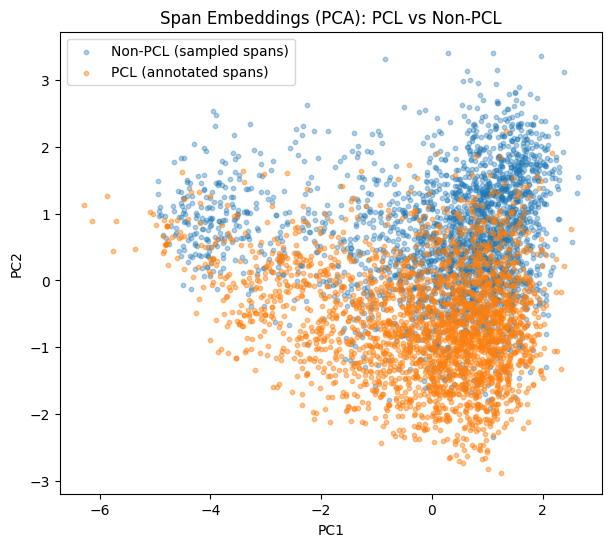

In [162]:
Z = PCA(n_components=2, random_state=SEED).fit_transform(X_bin)

plt.figure(figsize=(7,6))
plt.scatter(Z[y_bin==0,0], Z[y_bin==0,1], s=10, alpha=0.35, label="Non-PCL (sampled spans)")
plt.scatter(Z[y_bin==1,0], Z[y_bin==1,1], s=10, alpha=0.45, label="PCL (annotated spans)")
plt.title("Span Embeddings (PCA): PCL vs Non-PCL")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()

In [163]:
# infer label columns from spans_agg
meta_cols = {"par_id","art_id","text","keyword","country_code","span_start","span_finish","span_text","n_annotators","num_labels","span_len","label"}
label_cols = [c for c in spans_agg.columns if c not in meta_cols]

abbr = {
    "Unbalanced_power_relations": "UPR",
    "Compassion": "COMP",
    "Authority_voice": "AUTH",
    "Shallow_solution": "SHAL",
    "Presupposition": "PRES",
    "Metaphors": "META",
    "The_poorer_the_merrier": "PTM",
}

def cat_str(row):
    labs = [c for c in label_cols if row.get(c,0)==1]
    labs = [abbr.get(c, c[:6].upper()) for c in labs]
    return ",".join(labs) if labs else "NONE"

pos_cat = spans_agg[["span_text"] + label_cols].copy()
pos_cat["category"] = pos_cat.apply(cat_str, axis=1)

# optionally focus on top categories to keep plot readable
top_cats = pos_cat["category"].value_counts().head(7).index.tolist()
pos_cat_plot = pos_cat[pos_cat["category"].isin(top_cats)].copy()

X_cat = embed_texts(pos_cat_plot["span_text"].tolist(), model_name="distilbert-base-uncased", max_length=96)
Z_cat = PCA(n_components=2, random_state=SEED).fit_transform(X_cat)

print("Plotting categories:", top_cats)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 2111.09it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Plotting categories: ['UPR', 'COMP', 'META', 'AUTH', 'PRES', 'SHAL', 'PTM']


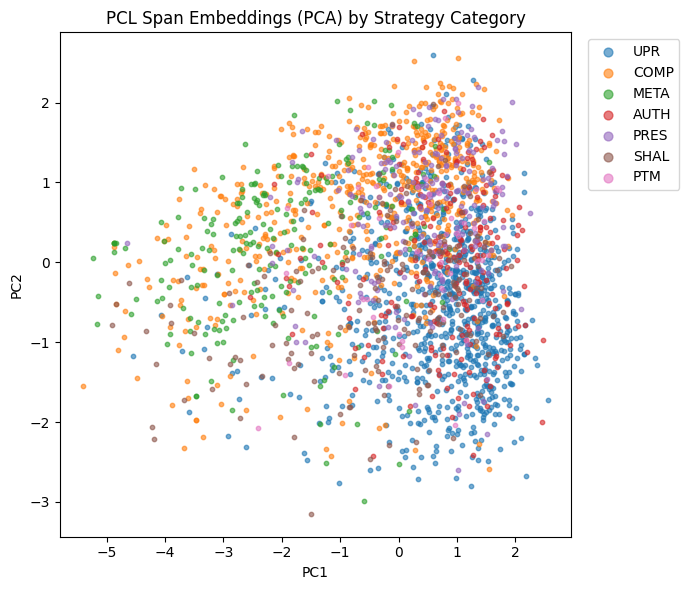

In [164]:
plt.figure(figsize=(7,6))
for cat in top_cats:
    m = (pos_cat_plot["category"].to_numpy() == cat)
    plt.scatter(Z_cat[m,0], Z_cat[m,1], s=10, alpha=0.6, label=cat)

plt.title("PCL Span Embeddings (PCA) by Strategy Category")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### t-SNE embeddings

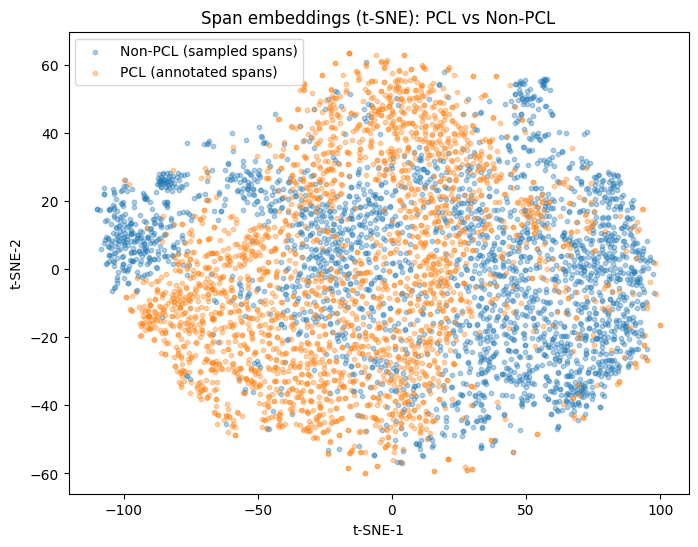

In [ ]:

from sklearn.manifold import TSNE

X50 = PCA(n_components=50, random_state=0).fit_transform(X_bin)

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate="auto",
    init="pca",
    random_state=0,
    max_iter=2500
)
Z = tsne.fit_transform(X50)

plt.figure(figsize=(8,6))
plt.scatter(Z[y_bin==0,0], Z[y_bin==0,1], s=10, alpha=0.35, label="Non-PCL (sampled spans)")
plt.scatter(Z[y_bin==1,0], Z[y_bin==1,1], s=10, alpha=0.35, label="PCL (annotated spans)")
plt.title("Span embeddings (t-SNE): PCL vs Non-PCL")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend()
plt.show()

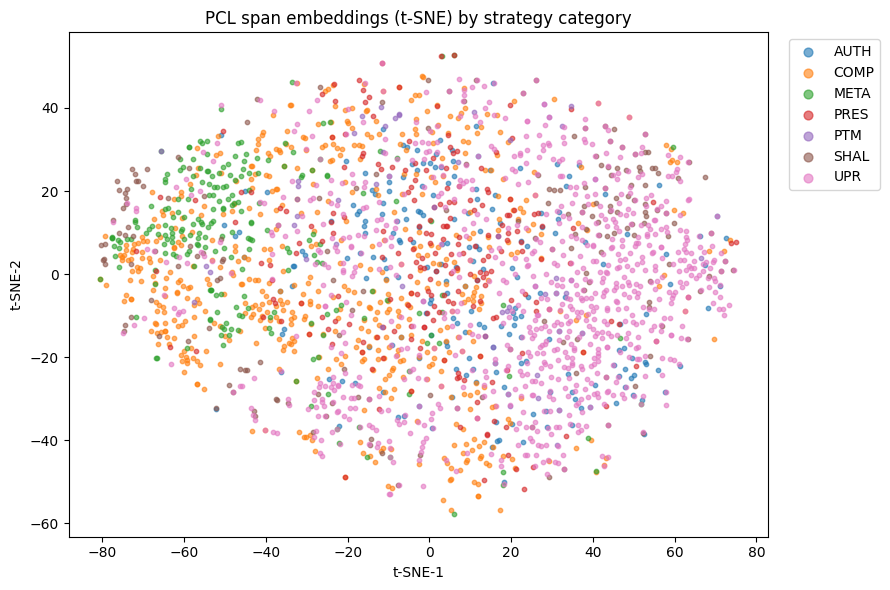

In [ ]:
span_cat = pos_cat_plot["category"].to_numpy()

X50_cat = PCA(n_components=50, random_state=0).fit_transform(X_cat)

tsne_cat = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate="auto",
    init="pca",
    random_state=0,
    max_iter=2500
)
Z_cat = tsne_cat.fit_transform(X50_cat)

plt.figure(figsize=(9,6))
for cat in np.unique(span_cat):
    m = (span_cat == cat)
    plt.scatter(Z_cat[m,0], Z_cat[m,1], s=10, alpha=0.6, label=str(cat))
plt.title("PCL span embeddings (t-SNE) by strategy category")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

Left side (green/orange heavy)
 - Metaphors
 - Compassion
 - Narrative/emotional language

Right side (pink heavy)
 - Unbalanced_power_relations
 - Moral framing / societal statements
 - Normative claims

This means the model already encodes a latent dimension:

emotional rhetoric  <-->  structural moral judgement

In [167]:
# Embedding helper (matches your earlier span embedding setup)

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"

MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()


@torch.no_grad()
def embed_text_list(texts, batch_size=32, max_length=256):
    all_embs = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(DEVICE)

        out = model(**enc)

        # CLS token embedding
        cls = out.last_hidden_state[:,0,:]

        all_embs.append(cls.cpu().numpy())

    return np.vstack(all_embs)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1891.25it/s, Materializing param=transformer.layer.5.sa_layer_norm.weight]   
DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [168]:
par_map = train_df.drop_duplicates("par_id").set_index("par_id")["text"].to_dict()
span_par_texts = span_bin_df["par_id"].map(par_map)

mask = span_par_texts.notna().to_numpy()
print("Missing parent paragraphs:", (~mask).sum(), "/", len(mask))

span_bin_df_ok = span_bin_df.loc[mask].reset_index(drop=True)
span_par_texts_ok = span_par_texts.loc[mask].astype(str).reset_index(drop=True)

X_bin_ok = X_bin[mask]
y_bin_ok = np.asarray(y_bin)[mask]

print("Filtered sizes:", len(span_bin_df_ok), X_bin_ok.shape, len(y_bin_ok))

Missing parent paragraphs: 572 / 5114
Filtered sizes: 4542 (4542, 768) 4542


100%|██████████| 142/142 [00:12<00:00, 11.67it/s]

        count      mean       std       min       25%       50%       75%  \
label                                                                       
0      2557.0  0.386938  0.068435  0.181324  0.340578  0.385211  0.433260   
1      1985.0  0.380629  0.071899  0.153841  0.330412  0.376016  0.426658   

            max  
label            
0      0.606984  
1      0.634718  



/var/folders/ms/m5smlvfd6t1bkvrzryzsdnbh0000gn/T/ipykernel_69109/516492353.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


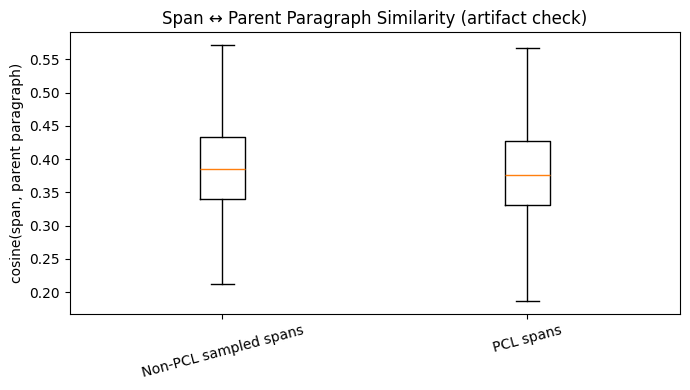

In [169]:
# embed parent paragraphs + cosine similarity plot

X_par_ok = embed_text_list(span_par_texts_ok.tolist())

sim = np.sum(X_bin_ok * X_par_ok, axis=1) / (
    (np.linalg.norm(X_bin_ok, axis=1) + 1e-9) * (np.linalg.norm(X_par_ok, axis=1) + 1e-9)
)

tmp = span_bin_df_ok[["label", "span_len"]].copy()
tmp["cos_sim_to_parent_par"] = sim

print(tmp.groupby("label")["cos_sim_to_parent_par"].describe())

plt.figure(figsize=(7,4))
plt.boxplot(
    [tmp.loc[tmp.label==0, "cos_sim_to_parent_par"],
     tmp.loc[tmp.label==1, "cos_sim_to_parent_par"]],
    labels=["Non-PCL sampled spans", "PCL spans"],
    showfliers=False
)
plt.ylabel("cosine(span, parent paragraph)")
plt.title("Span ↔ Parent Paragraph Similarity (artifact check)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

- Compared similiarity of spans to the source pargaph
    - basically both negative and positive spans are euqally different/similar to their parent paragraph
    - ... so the model cannot use this as a shortcut
- The signal must comeso  from wording style, not topic context.
- Equal similarity means the paragraph does not encode the label
    - therefore the model must rely on local wording
    - therefore span-level training is the correct abstraction


/var/folders/ms/m5smlvfd6t1bkvrzryzsdnbh0000gn/T/ipykernel_69109/2802787159.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  m = tmp.groupby(["len_bin","label"])["cos_sim_to_parent_par"].mean().unstack()


label,0,1
len_bin,,
"(0, 5]",0.458141,0.471005
"(5, 10]",0.393903,0.399587
"(10, 15]",0.378440,0.364180
"(15, 20]",0.376242,0.356185
"(20, 25]",0.376181,0.351055
"(25, 30]",0.379072,0.345663
"(30, 40]",0.372254,0.349781
"(40, 60]",0.372186,0.342624
"(60, 200]",NaN,0.329199


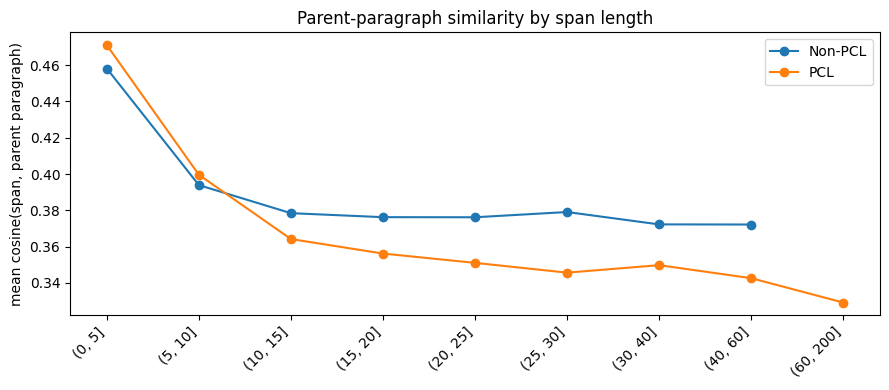

In [170]:
tmp["len_bin"] = pd.cut(tmp["span_len"], bins=[0,5,10,15,20,25,30,40,60,200])
m = tmp.groupby(["len_bin","label"])["cos_sim_to_parent_par"].mean().unstack()
display(m)

plt.figure(figsize=(9,4))
x = np.arange(len(m.index))
plt.plot(x, m[0], marker="o", label="Non-PCL")
plt.plot(x, m[1], marker="o", label="PCL")
plt.xticks(x, [str(b) for b in m.index], rotation=45, ha="right")
plt.ylabel("mean cosine(span, parent paragraph)")
plt.title("Parent-paragraph similarity by span length")
plt.legend()
plt.tight_layout()
plt.show()

- PCL spans diverge from their surrounding paragraph more than non-PCL spans → patronising language behaves like a stylistic insertion rather than normal narrative continuation.
- Paragraph embeddings act as a neutral baseline → the model detects PCL by deviation in tone/framing, not by topic.
- Supports span-level modeling (signal lives locally in wording), so whole-paragraph averaging weakens detectability.
    - since it is seen to be distinct from the surrounding style unlike non-PCL samples
- that being said most span lengths are around 10-20 size

Mean same-label fraction among 10-NN: 0.7809151349237389
count    5114.000000
mean        0.780915
std         0.236432
min         0.000000
25%         0.700000
50%         0.900000
75%         1.000000
max         1.000000
dtype: float64


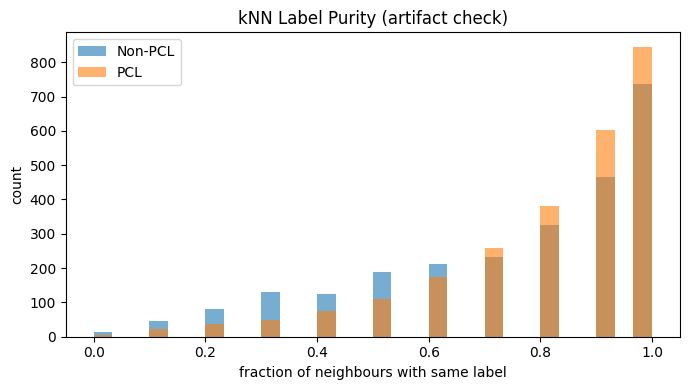

In [171]:
# If negatives cluster due to sampling artifact, kNN label-purity may be artificially high.

X = X_bin
y = np.asarray(y_bin)

k = 11  # includes self; effective neighbours = k-1
nn = NearestNeighbors(n_neighbors=k, metric="cosine").fit(X)
dist, idx = nn.kneighbors(X)

# exclude self (first neighbour is itself for cosine+exact same vector)
nbr_idx = idx[:, 1:]
nbr_labels = y[nbr_idx]

same_frac = (nbr_labels == y[:,None]).mean(axis=1)
print("Mean same-label fraction among 10-NN:", same_frac.mean())
print(pd.Series(same_frac).describe())

plt.figure(figsize=(7,4))
plt.hist(same_frac[y==0], bins=30, alpha=0.6, label="Non-PCL")
plt.hist(same_frac[y==1], bins=30, alpha=0.6, label="PCL")
plt.xlabel("fraction of neighbours with same label")
plt.ylabel("count")
plt.title("kNN Label Purity (artifact check)")
plt.legend()
plt.tight_layout()
plt.show()

- Nearby spans tend to share the same label → PCL forms local semantic pockets.
- Separation is contextual (local), not global clustering.